# Schematics for huge diffraction simulation libraries

Colin Ophus - 2024 May 1

This notebook contains functions to draw schematics for diffraction simulations as a function of orientation and thickness.

In [1]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
print(py4DSTEM.__version__)
import joblib

0.13.13


# variables and setup

In [2]:
k_max = 2.0
E0 = 300e3

In [3]:
crystal = joblib.load('data/mp-1xtal.joblib')


In [4]:
def draw_schematic(
    crystal,
    k_max,
    E0,
    ZA_corners,
    ZA_steps = 3,
    thickness_arange = (20,540,40),
    figsize = (12,8),
    dxy1 = (-0.6,-0.8),
    dxy2 = (0.6,-0.8),
    dxyt = (-0.006,-0.0015),
    xy_scale = 0.5,
    xlim = (-3.1,2.9),
    ylim = (-3.8,0.6),
    int_thresh = 1e-4,
    int_scale = 2e3,
    int_max = 100,
    rotation = 70*np.pi/180,
    alpha_initial = 0.15,
):
    """
    Function to draw overlapping diffraction patterns as schematics.
    """

    # inputs
    thickness = np.arange(thickness_arange[0],thickness_arange[1],thickness_arange[2])
    dxy1 = np.array(dxy1)
    dxy2 = np.array(dxy2)
    dxyt = np.array(dxyt)
    ZA_corners = np.array(ZA_corners)
    v = np.linspace(0,1,ZA_steps)
    
    # colors
    cvals = np.array([
        [1,0,0],
        [0,0.5,1.0],
        [0,0.5,0],
    ])
    
    
    
    # Plotting
    fig,ax = plt.subplots(figsize = figsize)
    for ry in range(ZA_steps):
        for rx in range(ZA_steps):
            if v[rx] + v[ry] <= 1.0:

                ZA = ZA_corners[0,:] * (1 - v[rx] - v[ry]) + \
                    ZA_corners[1,:] * v[rx] + \
                    ZA_corners[2,:] * v[ry]

                c = cvals[0,:] * (1 - v[rx] - v[ry])**0.5 + \
                    cvals[1,:] * v[rx]**0.5 + \
                    cvals[2,:] * v[ry]**0.5
                c = np.clip(c,0,1)
                
                beams = crystal.generate_diffraction_pattern(
                    zone_axis_lattice = ZA, 
                    sigma_excitation_error = 0.02,
                    tol_intensity = 0.0, 
                    k_max = k_max*2.0,
                )
                
                for a0 in range(1,thickness.size):    
                    pattern = crystal.generate_dynamical_diffraction_pattern(
                        beams = beams, 
                        thickness=thickness[a0], 
                        zone_axis_lattice=ZA,
                    )
                    xy = rx*dxy1 + ry*dxy2 + a0*dxyt
                    sub = np.logical_and(
                        pattern['intensity'] >= int_thresh,
                        pattern['qx']**2 + pattern['qy']**2 <= k_max**2,
                    )
                    sig = np.clip(
                        pattern['intensity'][sub] * int_scale,
                        1e-3,
                        int_max,
                    )
                    x = pattern['qx'][sub]*np.cos(rotation) - pattern['qy'][sub]*np.sin(rotation)
                    y = pattern['qx'][sub]*np.sin(rotation) + pattern['qy'][sub]*np.cos(rotation)
                    ax.scatter(
                        x*xy_scale + xy[0],
                        y*xy_scale + xy[1],
                        s = sig,
                        color = c,
                        alpha = alpha_initial * (a0/thickness.size)**1,
                        linewidths=0,
                    )

                # marker in front
                print(ZA)
                pattern = crystal.generate_dynamical_diffraction_pattern(
                    beams = beams, 
                    thickness=thickness[0], 
                    zone_axis_lattice=ZA,
                )
                xy = rx*dxy1 + ry*dxy2 + a0*dxyt
                sub = np.logical_and(
                    pattern['intensity'] >= int_thresh,
                    pattern['qx']**2 + pattern['qy']**2 <= k_max**2,
                )
                sig = np.clip(
                    pattern['intensity'][sub] * int_scale,
                    1e-3,
                    int_max,
                )
                x = pattern['qx'][sub]*np.cos(rotation) - pattern['qy'][sub]*np.sin(rotation)
                y = pattern['qx'][sub]*np.sin(rotation) + pattern['qy'][sub]*np.cos(rotation)
                ax.scatter(
                    x*xy_scale + xy[0],
                    y*xy_scale + xy[1],
                    s = sig,
                    color = c,
                    # alpha = 0.5,
                    linewidths=0,
                )

    
    # appearance
    ax.set_aspect('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')

    
    return fig,ax


[0. 0. 1.]
[0.   0.25 1.  ]
[0.  0.5 1. ]
[0.   0.75 1.  ]
[0. 1. 1.]
[0.25 0.25 1.  ]
[0.25 0.5  1.  ]
[0.25 0.75 1.  ]
[0.25 1.   1.  ]
[0.5 0.5 1. ]
[0.5  0.75 1.  ]
[0.5 1.  1. ]
[0.75 0.75 1.  ]
[0.75 1.   1.  ]
[1. 1. 1.]


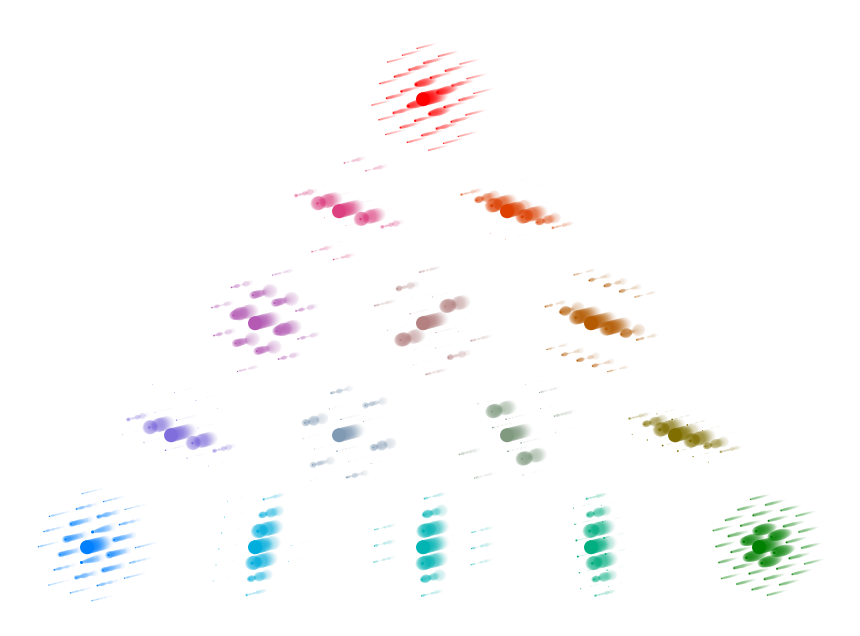

In [5]:
fig,ax = draw_schematic(
    crystal,
    0.8,
    E0,
    ZA_steps=5,
    thickness_arange=(20,1040,40),
    ZA_corners = [
        [0,0,1],
        [0,1,1],
        [1,1,1],
    ],
    # rotation = 0,
    alpha_initial = 0.225, 
)

In [49]:
fig.savefig('schematic04.png')

# Testing

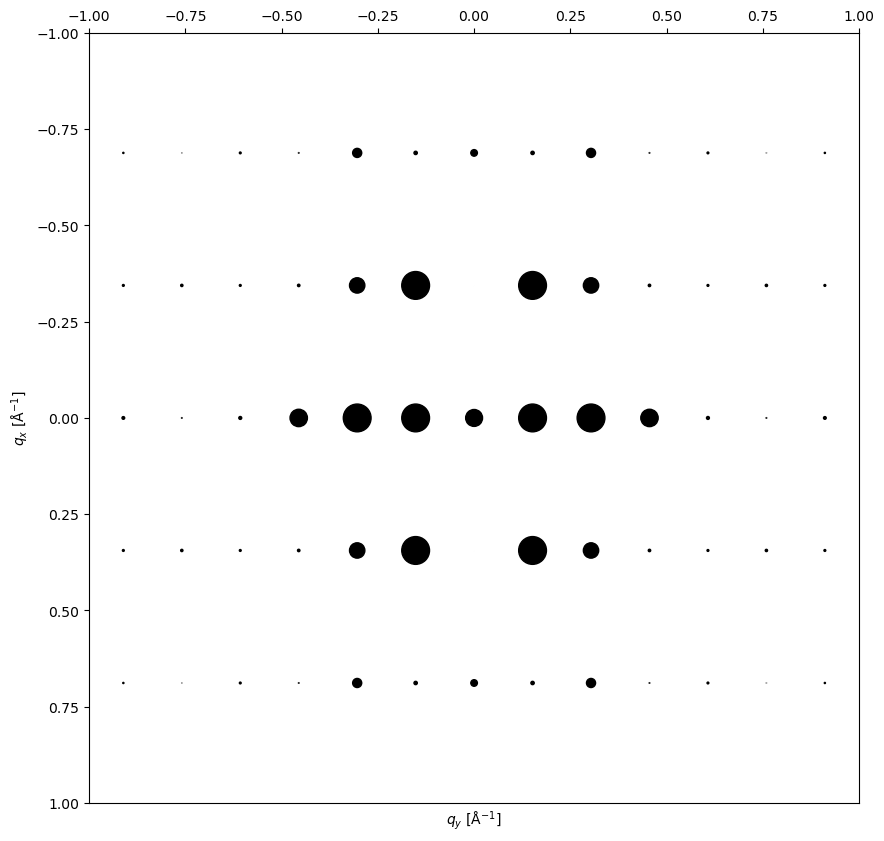

In [44]:
ZA = (0,1,0)

beams = crystal.generate_diffraction_pattern(
    zone_axis_lattice=ZA, 
    sigma_excitation_error=0.02,
    tol_intensity=0.0, 
    k_max=k_max * 2.0,
)

pattern = crystal.generate_dynamical_diffraction_pattern(
    beams=beams, 
    thickness=300, 
    zone_axis_lattice=ZA,
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    pattern,
    max_marker_size = 400,
    scale_markers = 1e4,
    power_markers = 2,
    add_labels=False,
    figsize = (10,10),
    plot_range_kx_ky = 1.0,
)

array([-2.09353874e-16,  6.88420981e-01,  3.44210490e-01, -1.93249730e-16,
       -3.44210490e-01, -6.88420981e-01,  1.03263147e+00,  6.88420981e-01,
        3.44210490e-01, -1.77145586e-16, -3.44210490e-01, -6.88420981e-01,
       -1.03263147e+00,  1.03263147e+00,  6.88420981e-01,  3.44210490e-01,
       -1.61041442e-16, -3.44210490e-01, -6.88420981e-01, -1.03263147e+00,
        1.37684196e+00,  1.03263147e+00,  6.88420981e-01,  3.44210490e-01,
       -1.44937297e-16, -3.44210490e-01, -6.88420981e-01, -1.03263147e+00,
       -1.37684196e+00,  1.37684196e+00,  1.03263147e+00,  6.88420981e-01,
        3.44210490e-01, -1.28833153e-16, -3.44210490e-01, -6.88420981e-01,
       -1.03263147e+00, -1.37684196e+00,  1.37684196e+00,  1.03263147e+00,
        6.88420981e-01,  3.44210490e-01, -1.12729009e-16, -3.44210490e-01,
       -6.88420981e-01, -1.03263147e+00, -1.37684196e+00,  1.72105245e+00,
        1.37684196e+00,  1.03263147e+00,  6.88420981e-01,  3.44210490e-01,
       -9.66248649e-17, -

In [68]:
crystal.orientation_plan(
    angle_step_zone_axis = 30.0,
    calculate_correlation_array = False,
)

In [32]:
# # Plot the structure
# crystal.plot_structure(
#     # zone_axis_lattice=[5,3,1],
#     zone_axis_lattice=[3,2,1],
#     figsize=(4,4),
#     # size_marker = 50,
# )

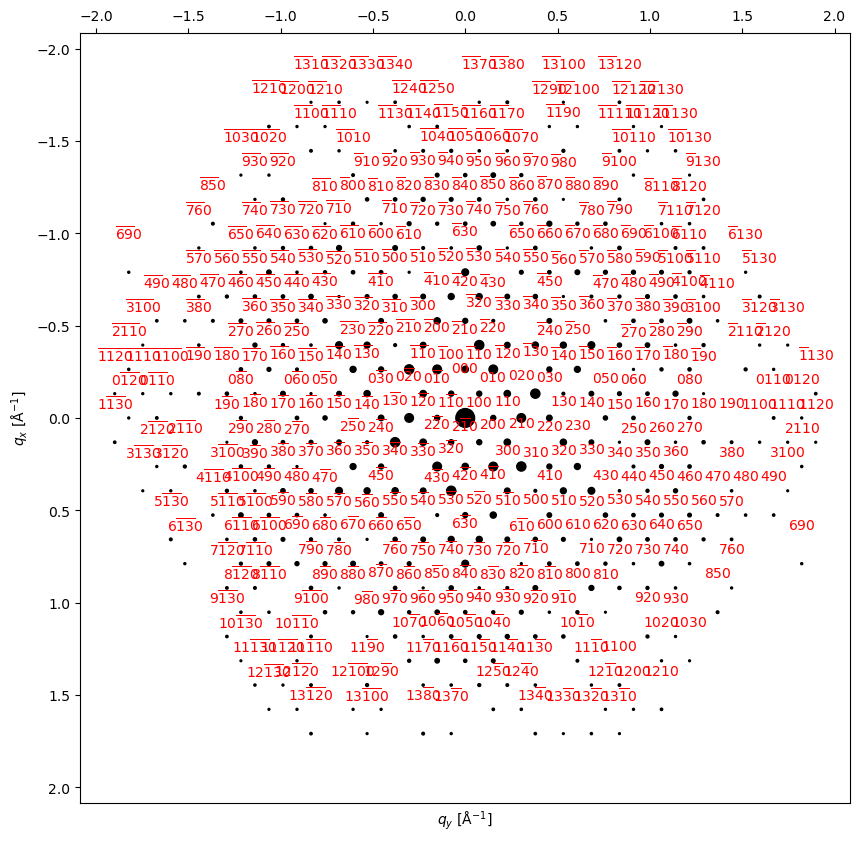

In [43]:
za = (0,0,1)

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis_lattice = za,
    # proj_x_lattice = x_proj_test,
    sigma_excitation_error=0.02
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks,
    # add_labels=False,
    shift_labels=0.2,
    figsize = (10,10),
)

In [52]:

crystal.calculate_structure_factors(
    k_max=k_max, 
    tol_structure_factor=-1.0,
)
crystal.calculate_dynamical_structure_factors(
    300e3, "WK-CP", k_max = k_max * 2.0, thermal_sigma=0.08, tol_structure_factor=-1.0
)

In [53]:
ZA = np.array([0, 0, 1])  # Use the (011) zone axis

beams = crystal.generate_diffraction_pattern(
    zone_axis_lattice=ZA, 
    sigma_excitation_error=0.02,
    tol_intensity=0.0, 
    k_max=k_max * 2.0,
)


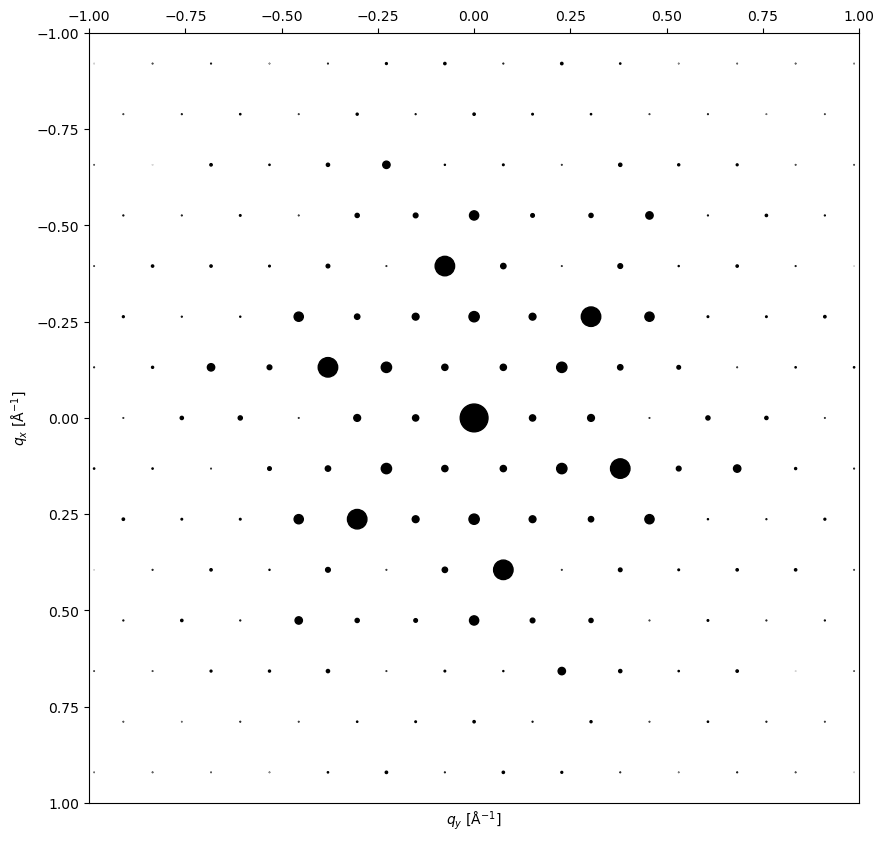

In [62]:
# Generate a dynamical diffraction pattern, at the specified thickness.# 
# The dynamical pattern will contain the same diffraction spots as `beams`, but
# the intensities now accurately include multiple scattering and absorption!

# note for example the 200 and -200 beams now have some intensity due to multiple scattering (for the [011] zone axis).

thickness = 400  # Ångström - feel free to tweak this


pattern = crystal.generate_dynamical_diffraction_pattern(
    beams=beams, 
    thickness=thickness, 
    zone_axis_lattice=ZA,
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    pattern,
    max_marker_size = 400,
    scale_markers = 1e4,
    power_markers = 2,
    add_labels=False,
    figsize = (10,10),
    plot_range_kx_ky = 1.0,
)